In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays, u_met
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
import pickle as pkl
import glob

coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
filetag = 'srfc'
era_hour = 12

In [4]:
#node_days = pkl.load(open(cnst.network_data + 'data/SOMS/saves/node3_MCS_matchTable.p', "rb"))
node_days = pd.read_csv(cnst.DATA + '/SOMS/saves/3x3_Nodes_fullYear/mcs_matchtable/node3_MCS_matchTable_mergedNodes_5mmMCS_fullYear.csv', index_col=0, parse_dates=True)

In [5]:
pd.to_datetime(node_days.index)[0].replace(hour=5)

Timestamp('2004-04-09 05:30:00')

In [6]:
node_days

,prcp,q925,q650,t925,shear,month,hour,year,day,area,tmin,rh,tcwv,lat,lon
2004-04-09 17:30:00,57.492078,14.864393,7.199410,23.502893,10.523680,4,17,2004,9,27750,-86.092362,76.939026,52.285583,5.724071,8.973695
2004-04-09 18:30:00,7.863972,15.635261,6.705916,21.926111,9.565559,4,18,2004,9,31125,-78.286962,88.278519,53.875740,5.653775,-7.859103
2004-04-09 18:30:00,7.394670,15.360639,6.578586,23.179956,12.729914,4,18,2004,9,17525,-77.938944,79.572632,48.113495,7.829097,-9.373507
2004-04-09 18:30:00,8.123865,14.202960,5.793951,26.281183,10.709904,4,18,2004,9,20025,-79.788394,61.539886,41.596397,8.344686,-7.975895
2004-04-18 17:30:00,15.544726,16.742010,4.550581,23.713800,13.958126,4,17,2004,18,6700,-87.000000,84.342255,48.962021,6.564383,6.111521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-07 17:00:00,8.925340,15.479974,6.129366,20.829523,2.507865,8,17,2015,7,6900,-69.979939,92.618835,55.035545,7.709709,6.793712
2015-08-07 18:00:00,12.086042,15.479974,6.129366,20.829523,2.507865,8,18,2015,7,5775,-75.343800,92.618835,55.035545,7.445678,6.269572
2015-08-07 18:00:00,8.797677,15.386710,6.879452,25.665247,6.217617,8,18,2015,7,8100,-67.946098,68.634430,42.959145,9.069827,9.287769
2015-08-07 18:30:00,24.130327,14.926009,7.460207,22.632257,0.331555,8,18,2015,7,9700,-78.000000,79.992493,49.117531,7.911274,-9.156312


In [7]:
def save_node_clim(filetag, node, era_hour):
    
    nodestr = 'node'+str(node)
    node_days = pd.read_csv(cnst.DATA + '/SOMS/saves/3x3_Nodes_fullYear/mcs_matchtable/'+nodestr+'_MCS_matchTable_mergedNodes_5mmMCS_fullYear.csv', index_col=0, parse_dates=True)
    #node_days = pkl.load(open(cnst.network_data + 'data/SOMS/saves/3x3/MCStable_3x3_5-9N/'+nodestr+'_MCS_matchTable.p', "rb"))
    
    #### potentially reduce MCS box here
    region = (node_days.lat>5) & (node_days.lat<8) & (node_days.lon>-10) & (node_days.lon<10)
    node_days = node_days[region]
    
#     node_days_era = []
#     for nd in node_days.index:
#         node_days_era.append(nd.replace(hour=era_hour))
#     node_days_era = pd.Series(node_days_era).values

    node_days_era = []
    for nd in node_days.index:
        node_days_era.append(nd)
    node_days_era = pd.Series(node_days_era).values
        
    if filetag == 'pl':
        fft = 'pressure_levels'
    else:
        fft = 'surface'
        
    filebase = cnst.other_drive + '/ERA5_WAf/hourly/' 
    filepath = filebase + fft+'/ERA5*'+filetag+'.nc'
    out = cnst.DATA + 'SOMS/saves/3x3_Nodes_fullYear/'+nodestr+'_ERA5_5MCS_5mm_mean_5-8N_'+filetag+'.nc'
    outdev = cnst.DATA + 'SOMS/saves/3x3_Nodes_fullYear/'+nodestr+'_ERA5_5MCS_5mm_stddev_5-8N_'+filetag+'.nc'
    
    def means(da, node_days):
        da = da.sel(time=(da['time.hour']==era_hour))
        try:
            da = da.sel(level=[925,850,750,650,550,250])
        except:
            pass
        
        if (filetag == 'pl'):
            if not 'z' in da.data_vars:
                ipdb.set_trace()
                
        dal = []

        u, inv = np.unique(node_days, return_inverse=True)
        n = np.bincount(inv)
        goodinds = u[(n>=5)] #minimum 5 MCS per MCS day (5 in one hour)
        goodinds = pd.Series(goodinds)
        goodins_erahour = []
   
        for nd in goodinds:
            goodins_erahour.append(nd.replace(hour=era_hour, minute=0))
        
        goodins_erahour = np.unique(goodins_erahour)
        goodins_erahour = pd.Series(goodins_erahour).values
        
        #ipdb.set_trace()
        intersect_dates = np.intersect1d(goodins_erahour, da.time.values)
        if len(intersect_dates) == 0:
            return None
        try:
            da = da.sel(time=intersect_dates)
        except:
            return None

        da = u_darrays.flip_lat(da)
        return da
    
    srfc_list = []
    
    for f in glob.glob(filepath):
        print('Doing', f)
        srfc = xr.open_dataset(f) 
        srfc_concat = means(srfc,node_days_era)
        if srfc_concat is None:
            continue

        srfc_list.append(srfc_concat)
    
    full = xr.concat(srfc_list, dim='time')
    #ipdb.set_trace()
    mean = full.mean('time')
    dev = full.std('time')
    
    mean.to_netcdf(out)
    dev.to_netcdf(outdev)

In [30]:
for ni in range(1,10):
#     nodestr='node'+str(1)
#     all_node_file = pkl.load(open(cnst.network_data + 'data/SOMS/saves/node_days.p', "rb"))
#     node_days = all_node_file[nodestr]
#     node_days_era = []
#     for nd in node_days:
#         node_days_era.append(nd.replace(hour=era_hour))
        
    save_node_clim(filetag, ni, era_hour)

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_11_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1991_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1993_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1994_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1996_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1997_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2005_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2006_03_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_07_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_04_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_04_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_11_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2005_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2006_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2007_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2007_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2009_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2013_11_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_10_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_02_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1993_04_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_11_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2005_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2006_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2007_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2007_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2009_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2013_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2015_06_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_10_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_12_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_01_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_07_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2005_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2006_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2007_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2007_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2009_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2013_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2015_06_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1991_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1991_02_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2018_08_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_04_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_11_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1991_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1993_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1994_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1996_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1997_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2005_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2006_03_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_02_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_11_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1982_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1982_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_09_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_09_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1991_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1993_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1994_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1996_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1997_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2005_01_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_05_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_06_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_01_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1979_02_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1980_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1982_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1984_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1991_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1993_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1994_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1996_02_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1989_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1990_02_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2010_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2017_09_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1982_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1982_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1988_05_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2002_01_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1980_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1982_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1984_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_10_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1987_04_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1998_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1998_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1998_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1998_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1998_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_06_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_11_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2011_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_07_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2003_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2003_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2003_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2003_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2003_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2004_06_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1985_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1985_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1985_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1985_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1985_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1986_06_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1998_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1998_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1998_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1999_08_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1980_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1980_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1980_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1980_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1980_09_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1980_10_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1980_11_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1980_12_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_1981_03_srfc.nc
Doing /med

Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_01_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_02_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_03_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_04_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2012_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_05_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_06_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_07_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_08_srfc.nc
Doing /media/ck/LStorage/global_water/other//ERA5_WAf/hourly/surface/ERA5_2001_09_srfc.nc
Doing /med

[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.]
[0.3924731182795699, 1.4851190476190477, 2.532258064516129, 2.8027777777777776, 2.725806451612903, 2.22777777777

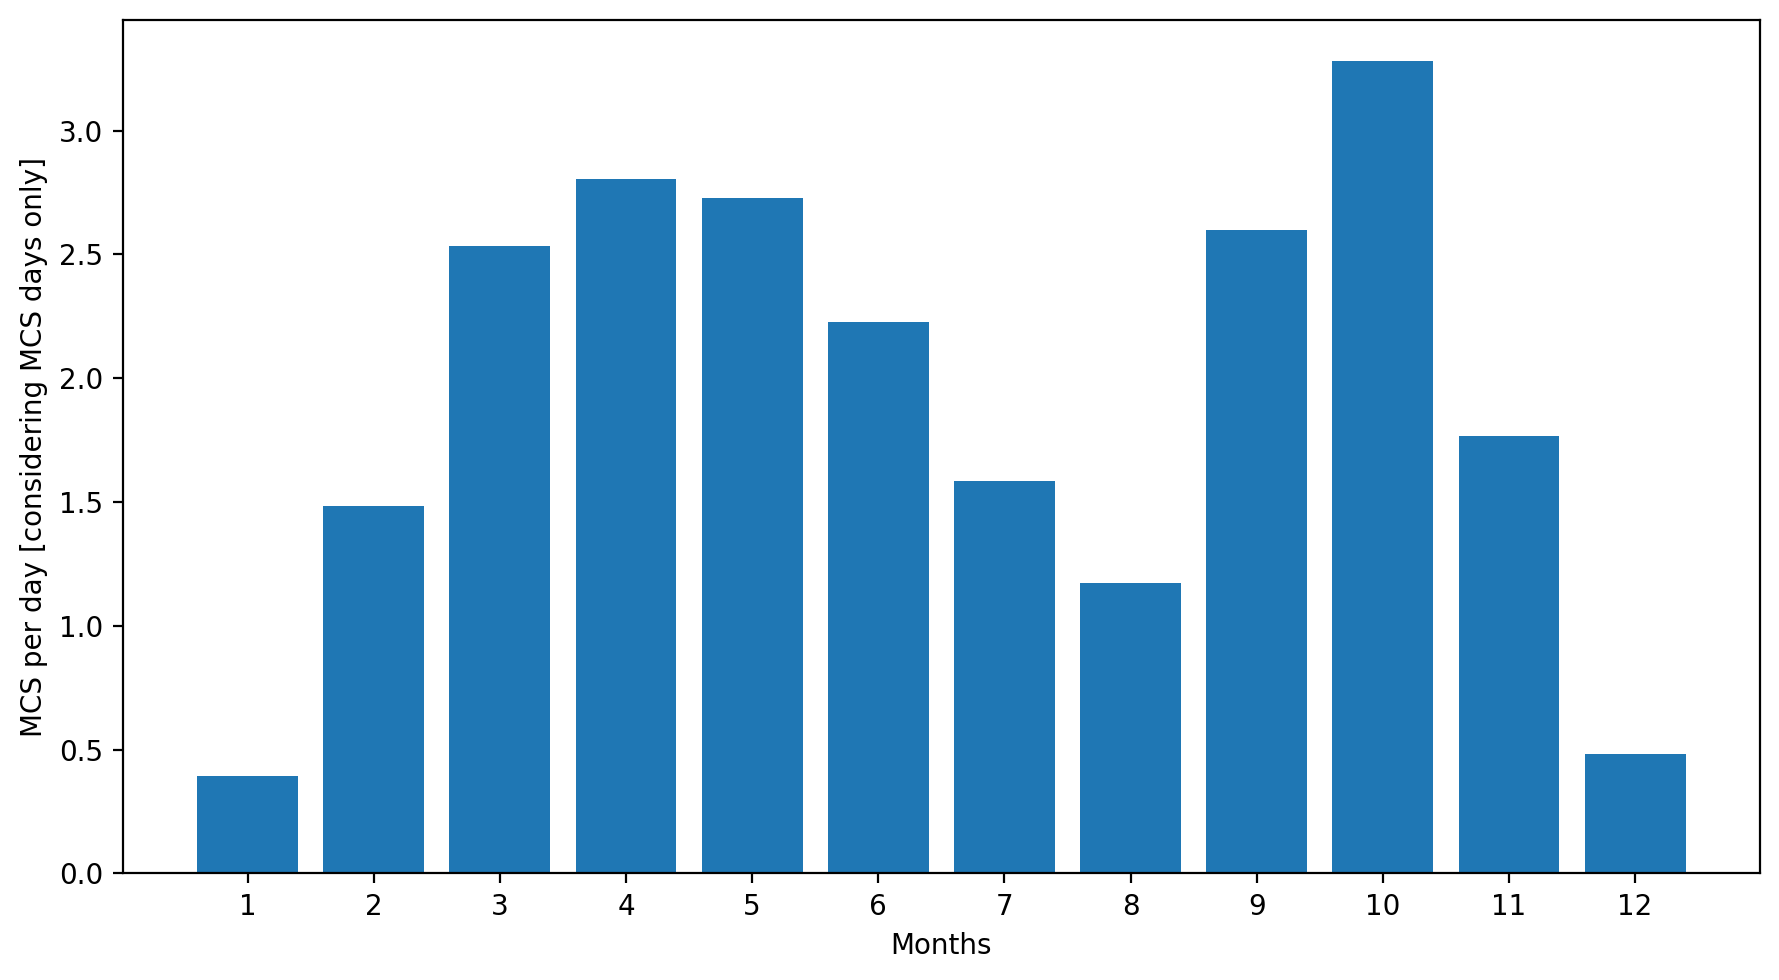

In [23]:
f = plt.figure(figsize=(9,5), dpi=200)

toconcat = []
for node in range(1,10):
    toconcat.append(pd.read_csv(cnst.DATA + '/SOMS/saves/3x3_Nodes_fullYear/mcs_matchtable/node'+str(node)+'_MCS_matchTable_mergedNodes_5mmMCS_fullYear.csv', index_col=0, parse_dates=True))
    
df = pd.concat(toconcat)
df = df.where(df.hour==18).dropna()
    
nmonth = []
ax = f.add_subplot(1,1,1)

mdays = [31,28,31,30,31,30,31,31,30,31,30,31]
for ni in range(1,13):
    nmonth.append(np.sum(df.month==ni)/(mdays[ni-1]*np.unique(df.year).size)) # note, divided by number of days in years 2004-2015! 
    print(np.unique(df.year))
print(nmonth)
ax.bar(np.arange(1,13).astype(int), np.array(nmonth))
ax.set_ylabel('MCS per day [considering MCS days only]')
ax.set_xlabel('Months')
#ax.set_title('Node:'+ str(node)+' '+merged_nodes_str[node-1])
ax.set_xticks(np.arange(1,13).astype(int))
    
plt.tight_layout()
#f.savefig(cnst.network_data + 'figs/SOMS/nb_node_permonth_nodes_fullYear.jpg')

In [8]:
all_node_file = pkl.load(open(cnst.network_data + 'data/SOMS/saves/3x3_Nodes_fullYear/node_days.p', "rb"))

In [9]:
(all_node_file['node1']).size

1624

In [ ]:
from utils import u_darrays as uda
f = plt.figure(figsize=(15,5), dpi=300)
mname = 'node'

for ids, m in enumerate(range(1,10)):
    
    
    pl_clim = xr.open_dataset(cnst.DATA + 'SOMS/saves/3x3_Nodes_fullYear/node1_ERA5_clim_mean_srfc.nc')
    #pl_clim = uda.flip_lat(pl_clim)
    pl_clim = pl_clim['cape'].sel(latitude=slice(3,10), longitude=slice(-12,12))
    pl_clim.values = pl_clim.values*0
    
    df = pd.read_csv(cnst.DATA + '/SOMS/saves/3x3_Nodes_fullYear/mcs_matchtable/node'+str(m)+'_MCS_matchTable_mergedNodes_5mmMCS_fullYear.csv', index_col=0, parse_dates=True)
    df = df.where(df.hour==18).dropna()
    anf = all_node_file['node'+str(m)]
    #ipdb.set_trace()
    anf = anf.where((anf.year>=2004)&(anf.year<=2015)).dropna()
    
    daycount = df.index.size/anf.size #*100 
    #ipdb.set_trace()

    for ix, dff in df.iterrows():

        xv = dff.lon
        yv = dff.lat

        loc = pl_clim.sel(longitude=xv, latitude=yv, method='nearest')
        xm, ym = np.meshgrid(pl_clim.longitude.values, pl_clim.latitude.values)
        ipos = np.where((xm==loc.longitude.values)&(ym==loc.latitude.values))
        try:
            pl_clim.values[ipos] = pl_clim.values[ipos]+1
        except:
            ipdb.set_trace()

    plots = pl_clim.values #/ anf.size *100
    
    ax = f.add_subplot(3,3,ids+1, projection=ccrs.PlateCarree())

    plt.contourf(pl_clim.longitude, pl_clim.latitude, plots, transform=ccrs.PlateCarree(), cmap='PuBuGn', extend='both', levels=np.arange(0,5))
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.title('MCS/day: '+str(np.round(daycount,1)))
    cbar = plt.colorbar()
    cbar.set_label('Total MCS (n)')
   
    
    
plt.tight_layout()
#f.savefig(cnst.network_data + 'figs/LSTA/corrected_LSTA/new/wavelet_coefficients/2hOverlap/maps.png')
        
        